In [153]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [126]:
# שלב 1: טעינת הנתונים
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
samp_sub =  pd.read_csv('sample_submission.csv')

In [127]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


C:\Users\avoav\AppData\Local\Temp\ipykernel_148084\1118072292.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});


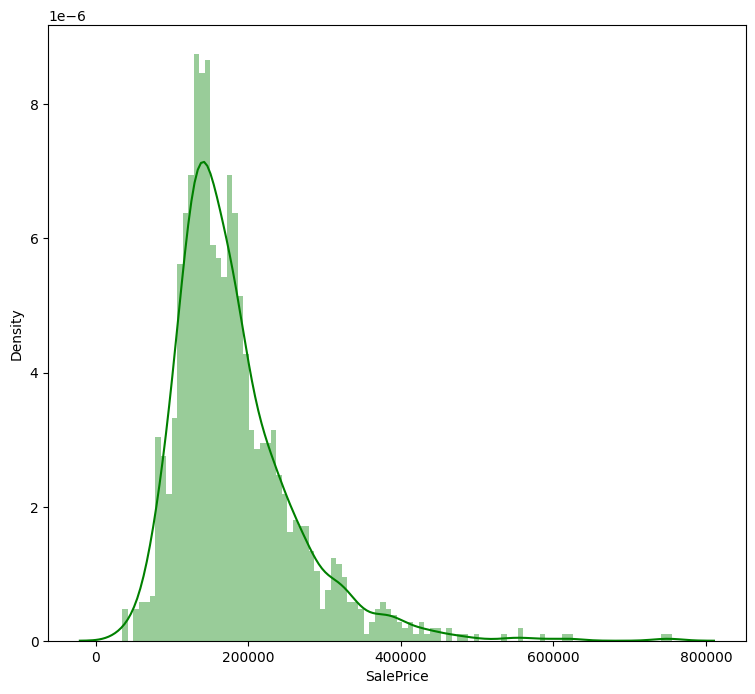

In [146]:
print(train_data['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(train_data['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [128]:

# שלב 2: הסרת עמודות עם פחות מ-100 ערכים שאינם NaN
train_data = train_data.dropna(thresh=100, axis=1)
test_data = test_data[train_data.columns.drop('SalePrice')]  # שמירת אותן עמודות גם ב-test data למעט עמודת המחיר


In [129]:
# זיהוי משתנים מספריים וקטגוריאליים
numerical_features = train_data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train_data.select_dtypes(include=['object']).columns


In [130]:
# שלב 3: חישוב קורלציות עם המחיר ומחיקת עמודות מספריות עם קורלציה נמוכה
correlation_matrix = train_data[numerical_features].corr()
price_correlation = correlation_matrix['SalePrice'].abs().sort_values(ascending=False)
threshold = 0.1  # סף לקורלציה נמוכה
high_corr_features = price_correlation[price_correlation > threshold].index

# שמירה על העמודות המספריות עם קורלציה גבוהה והוספת העמודות הקטגוריאליות
selected_features = list(high_corr_features) + list(categorical_features)
train_data = train_data[selected_features]
selected_features_noprice = [feature for feature in selected_features if feature != 'SalePrice']
test_data = test_data[selected_features_noprice]

In [131]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 67 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SalePrice      1460 non-null   int64  
 1   OverallQual    1460 non-null   int64  
 2   GrLivArea      1460 non-null   int64  
 3   GarageCars     1460 non-null   int64  
 4   GarageArea     1460 non-null   int64  
 5   TotalBsmtSF    1460 non-null   int64  
 6   1stFlrSF       1460 non-null   int64  
 7   FullBath       1460 non-null   int64  
 8   TotRmsAbvGrd   1460 non-null   int64  
 9   YearBuilt      1460 non-null   int64  
 10  YearRemodAdd   1460 non-null   int64  
 11  GarageYrBlt    1379 non-null   float64
 12  MasVnrArea     1452 non-null   float64
 13  Fireplaces     1460 non-null   int64  
 14  BsmtFinSF1     1460 non-null   int64  
 15  LotFrontage    1201 non-null   float64
 16  WoodDeckSF     1460 non-null   int64  
 17  2ndFlrSF       1460 non-null   int64  
 18  OpenPorc

In [132]:
# הפרדת משתנים לדאטה ולייבל
X_train = train_data.drop('SalePrice', axis=1)
y_train = train_data['SalePrice']
X_test = test_data
y_test = samp_sub['SalePrice']

In [154]:
# שלב 6: יצירת Pipelines לטיפול בערכים חסרים וקטגוריאליים ולהוספת TruncatedSVD
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # מילוי ערכים חסרים במספר ממוצע
    ('scaler', StandardScaler()),  # סטנדרטיזציה
    ('transformer', PowerTransformer())  # שינוי התפלגות הנתונים ללוגריתם או תפלגות אחרת
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # מילוי ערכים חסרים בערך הנפוץ ביותר
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # קידוד OneHot לערכים קטגוריאליים
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# הוספת TruncatedSVD לצמצום ממדיות ולאחר מכן MinMaxScaler לנרמול
pipeline_with_svd = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(n_components=50)),  # צמצום למספר רכיבים מתאים
    ('scaler', MinMaxScaler())  # נרמול
])

In [155]:
# שלב 7: עיבוד הנתונים עם TruncatedSVD
X_train_processed = pipeline_with_svd.fit_transform(X_train)
X_test_processed = pipeline_with_svd.transform(X_test)

In [156]:
X_train_processed


array([[0.94059254, 0.544677  , 0.46073828, ..., 0.44371543, 0.55005413,
        0.53871749],
       [0.69835035, 0.41342217, 0.34943437, ..., 0.43560259, 0.4463548 ,
        0.41926888],
       [0.81643087, 0.56820929, 0.45998511, ..., 0.43346187, 0.53763966,
        0.40321168],
       ...,
       [0.58582287, 0.45529693, 0.71066913, ..., 0.4857701 , 0.4433246 ,
        0.42057019],
       [0.67112867, 0.25194499, 0.29027224, ..., 0.68261053, 0.30419666,
        0.29657518],
       [0.79447324, 0.34825518, 0.33452737, ..., 0.57902405, 0.90081246,
        0.48032589]])

In [157]:
# שלב 4: חישוב מטריצת הקורלציה
numerical_features_0 = train_data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = train_data[numerical_features_0].corr()

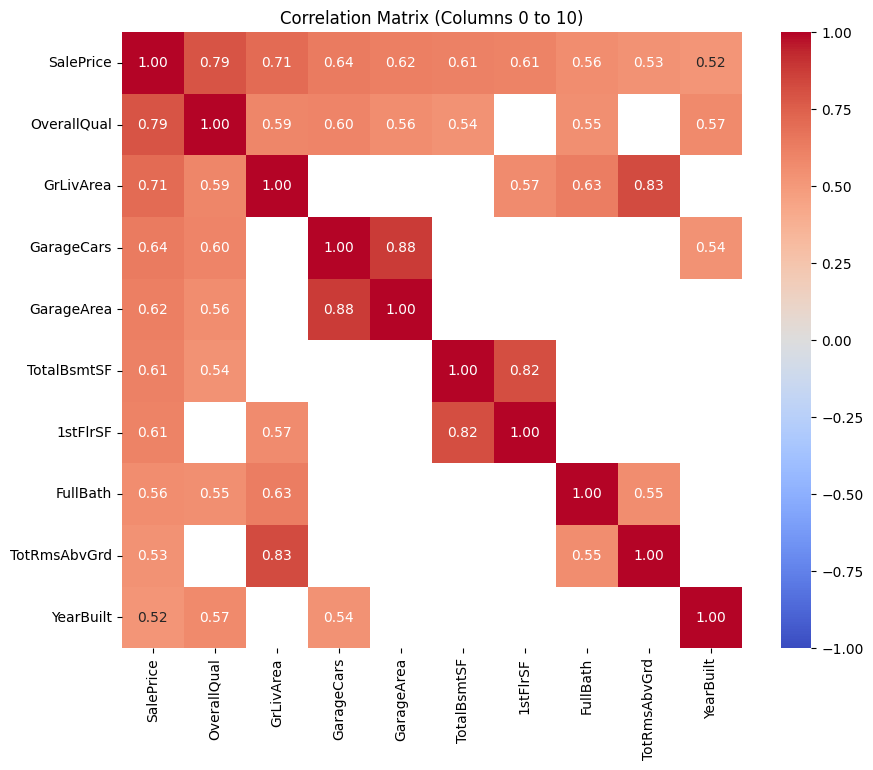

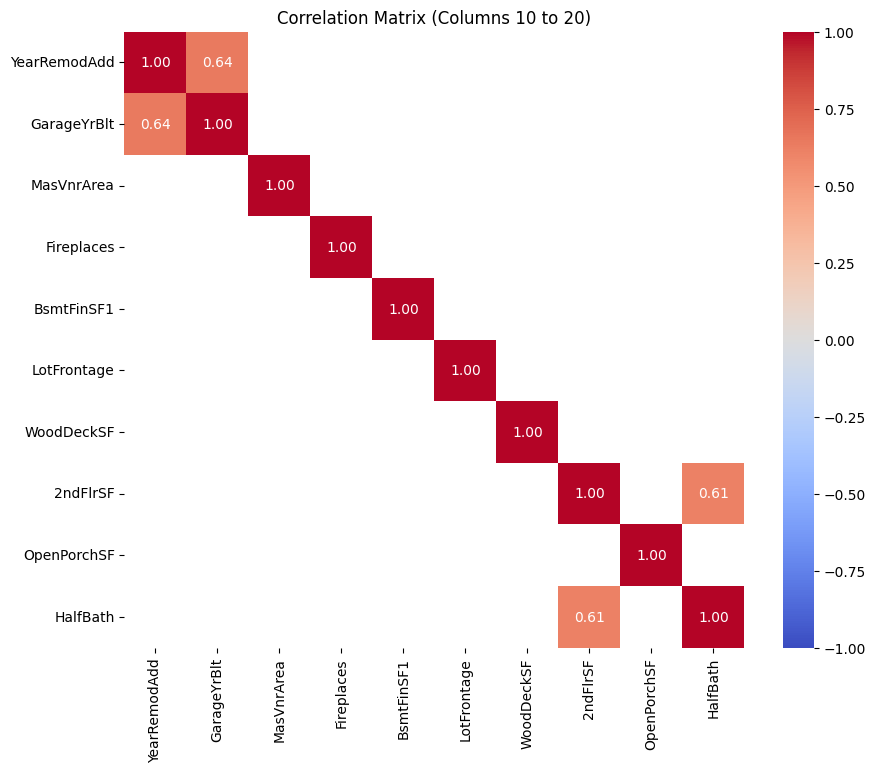

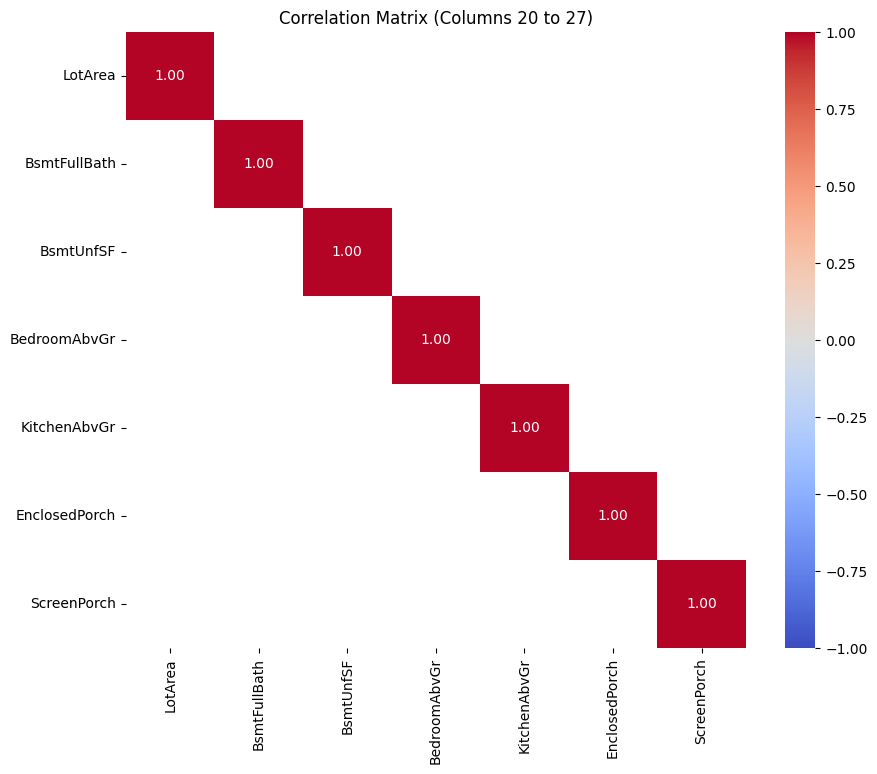

In [158]:
threshold = 0.5
high_corr_matrix = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]

# שלב 6: חלוקה לחלקים קטנים
step = 10  # מספר העמודות בכל חלק
for start in range(0, len(high_corr_matrix.columns), step):
    end = min(start + step, len(high_corr_matrix.columns))
    part = high_corr_matrix.iloc[start:end, start:end]
    
    # שלב 7: הצגת מפת חום לחלק מהנתונים
    plt.figure(figsize=(10, 8))
    sns.heatmap(part, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix (Columns {start} to {end})')
    plt.show()

קורלציות גבוהות עם מחיר הדירה:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


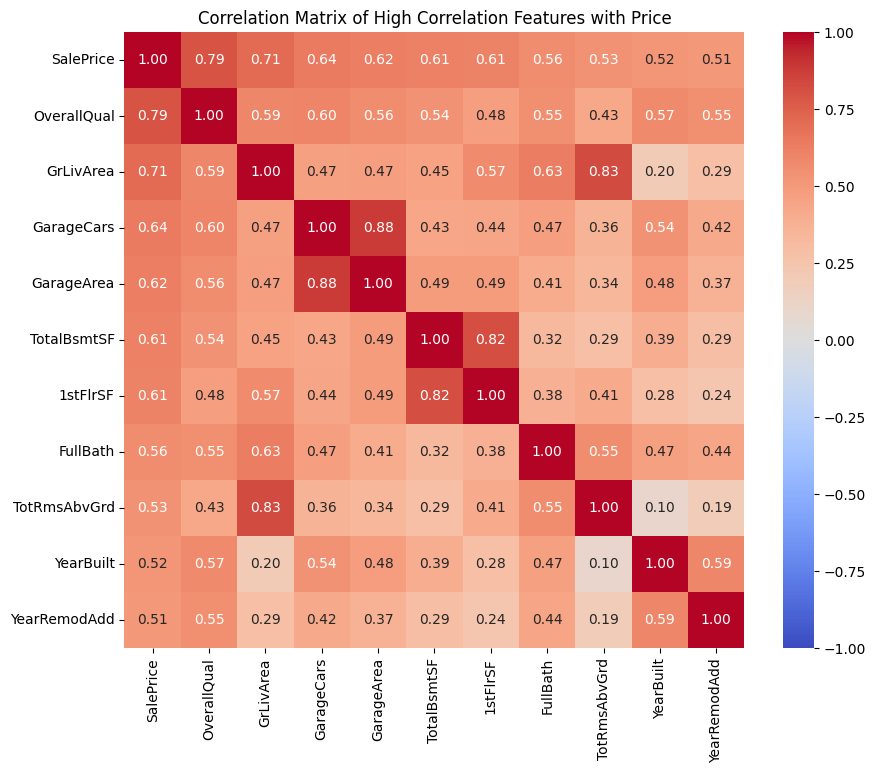

In [159]:

# שלב 5: בחירת עמודת המחיר
price_correlation = correlation_matrix['SalePrice'].sort_values(ascending=False)

# שלב 6: סינון ערכים עם קורלציה גבוהה
threshold = 0.5
high_price_corr = price_correlation[abs(price_correlation) >= threshold]

# שלב 7: הצגת הקורלציות
print("קורלציות גבוהות עם מחיר הדירה:")
print(high_price_corr)

# שלב 8: הצגת מפת חום של קורלציות גבוהות
plt.figure(figsize=(10, 8))
sns.heatmap(train_data[high_price_corr.index].corr(), annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of High Correlation Features with Price')
plt.show()

In [160]:
# שלב 6: הגדרת המודלים וכוונון היפר-פרמטרים באמצעות GridSearchCV
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "SVM": SVR(),
    "AdaBoost": AdaBoostRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}


In [161]:
model = LinearRegression()
model.fit(X_train_processed, y_train)
predictions = model.predict(X_test_processed)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
results["Linear Regression"] = {"MSE": mse, "R2": r2}
print(f"{"Linear Regression"} - MSE: {mse:.2f}, R2: {r2:.2f}")


Linear Regression - MSE: 5042112799.28, R2: -17.49


In [162]:
# פונקציה לכוונון היפר-פרמטרים
def tune_model(model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_processed, y_train)
    return grid_search.best_estimator_

# שלב 8: הגדרת המודלים וכוונון היפר-פרמטרים
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": tune_model(DecisionTreeRegressor(), {'max_depth': [5, 10, 20, None]}),
    "SVM": tune_model(SVR(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf']}),
    "AdaBoost": tune_model(AdaBoostRegressor(), {'n_estimators': [50, 100, 200]}),
    "K-Nearest Neighbors": tune_model(KNeighborsRegressor(), {'n_neighbors': [3, 5, 10]}),
    "Random Forest": tune_model(RandomForestRegressor(), {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 20, None]}),
    "Gradient Boosting": tune_model(GradientBoostingRegressor(), {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2]})
}

KeyboardInterrupt: 

In [123]:

# הרצת המודלים והדפסת התוצאות
results = {}
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    predictions = model.predict(X_test_processed)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[name] = {"MSE": mse, "R2": r2}
    print(f"{name} - MSE: {mse:.2f}, R2: {r2:.2f}")


Linear Regression - MSE: 5846118970.63, R2: -20.44
Decision Tree - MSE: 5538010597.01, R2: -19.31
SVM - MSE: 533190947.41, R2: -0.96
AdaBoost - MSE: 4887439176.84, R2: -16.92
K-Nearest Neighbors - MSE: 4249778414.05, R2: -14.59
Random Forest - MSE: 4890641783.19, R2: -16.94
Gradient Boosting - MSE: 5304772720.09, R2: -18.46


In [61]:
results = {}
for name, model in models.items():
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_processed, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model
        best_model.fit(X_train_processed, y_train)
    
    predictions = best_model.predict(X_test_processed)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[name] = {"MSE": mse, "R2": r2}

# הדפסת תוצאות
for name, metrics in results.items():
    print(f"{name} - MSE: {metrics['MSE']:.2f}, R2: {metrics['R2']:.2f}")


KeyboardInterrupt: 